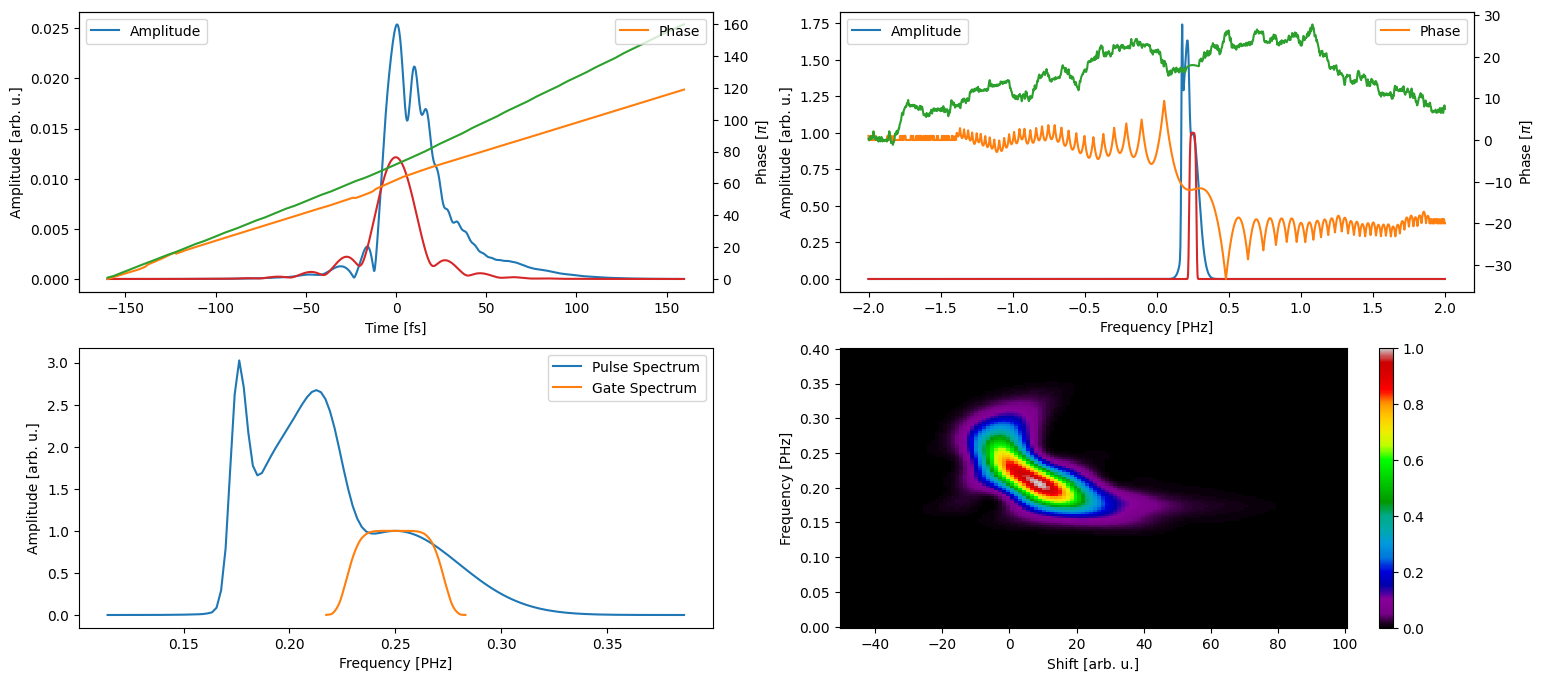

In [7]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp
import matplotlib.pyplot as plt
import refractiveindex

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = PolynomialPhase(None, (0,0,20,-30))

amp1 = GaussianAmplitude((1), (0.25), (0.05), (3))
phase1 = PolynomialPhase(None, (0,0,-20,30))

mp = MakeTrace(N=128*10, f_max=2)
time, frequency, pulse_t, pulse_f = mp.generate_pulse((amp0,phase0))

_, frequency_gate, _, pulse_f_gate = mp.generate_pulse((amp1,phase1))


# import refractiveindex
# parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
# z_arr = jnp.linspace(-5,5,128) 
# z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
#                                                                z_arr, phase_type="material", parameters=parameters,
#                                                                frequency_range=(0.1,0.65), N=128)



# theta = jnp.linspace(-1,10,128) 
# theta, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "pg", theta, phase_type="material",
#                                                                chirp_parameters=refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson"),
#                                                                N=128, frequency_range=(0,0.4))




delay = jnp.linspace(-50,100,128) 
delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "pg", delay,
                                                          cross_correlation=True,
                                                          gate=(frequency_gate, pulse_f_gate),
                                                          N=128, frequency_range=(0,0.4))


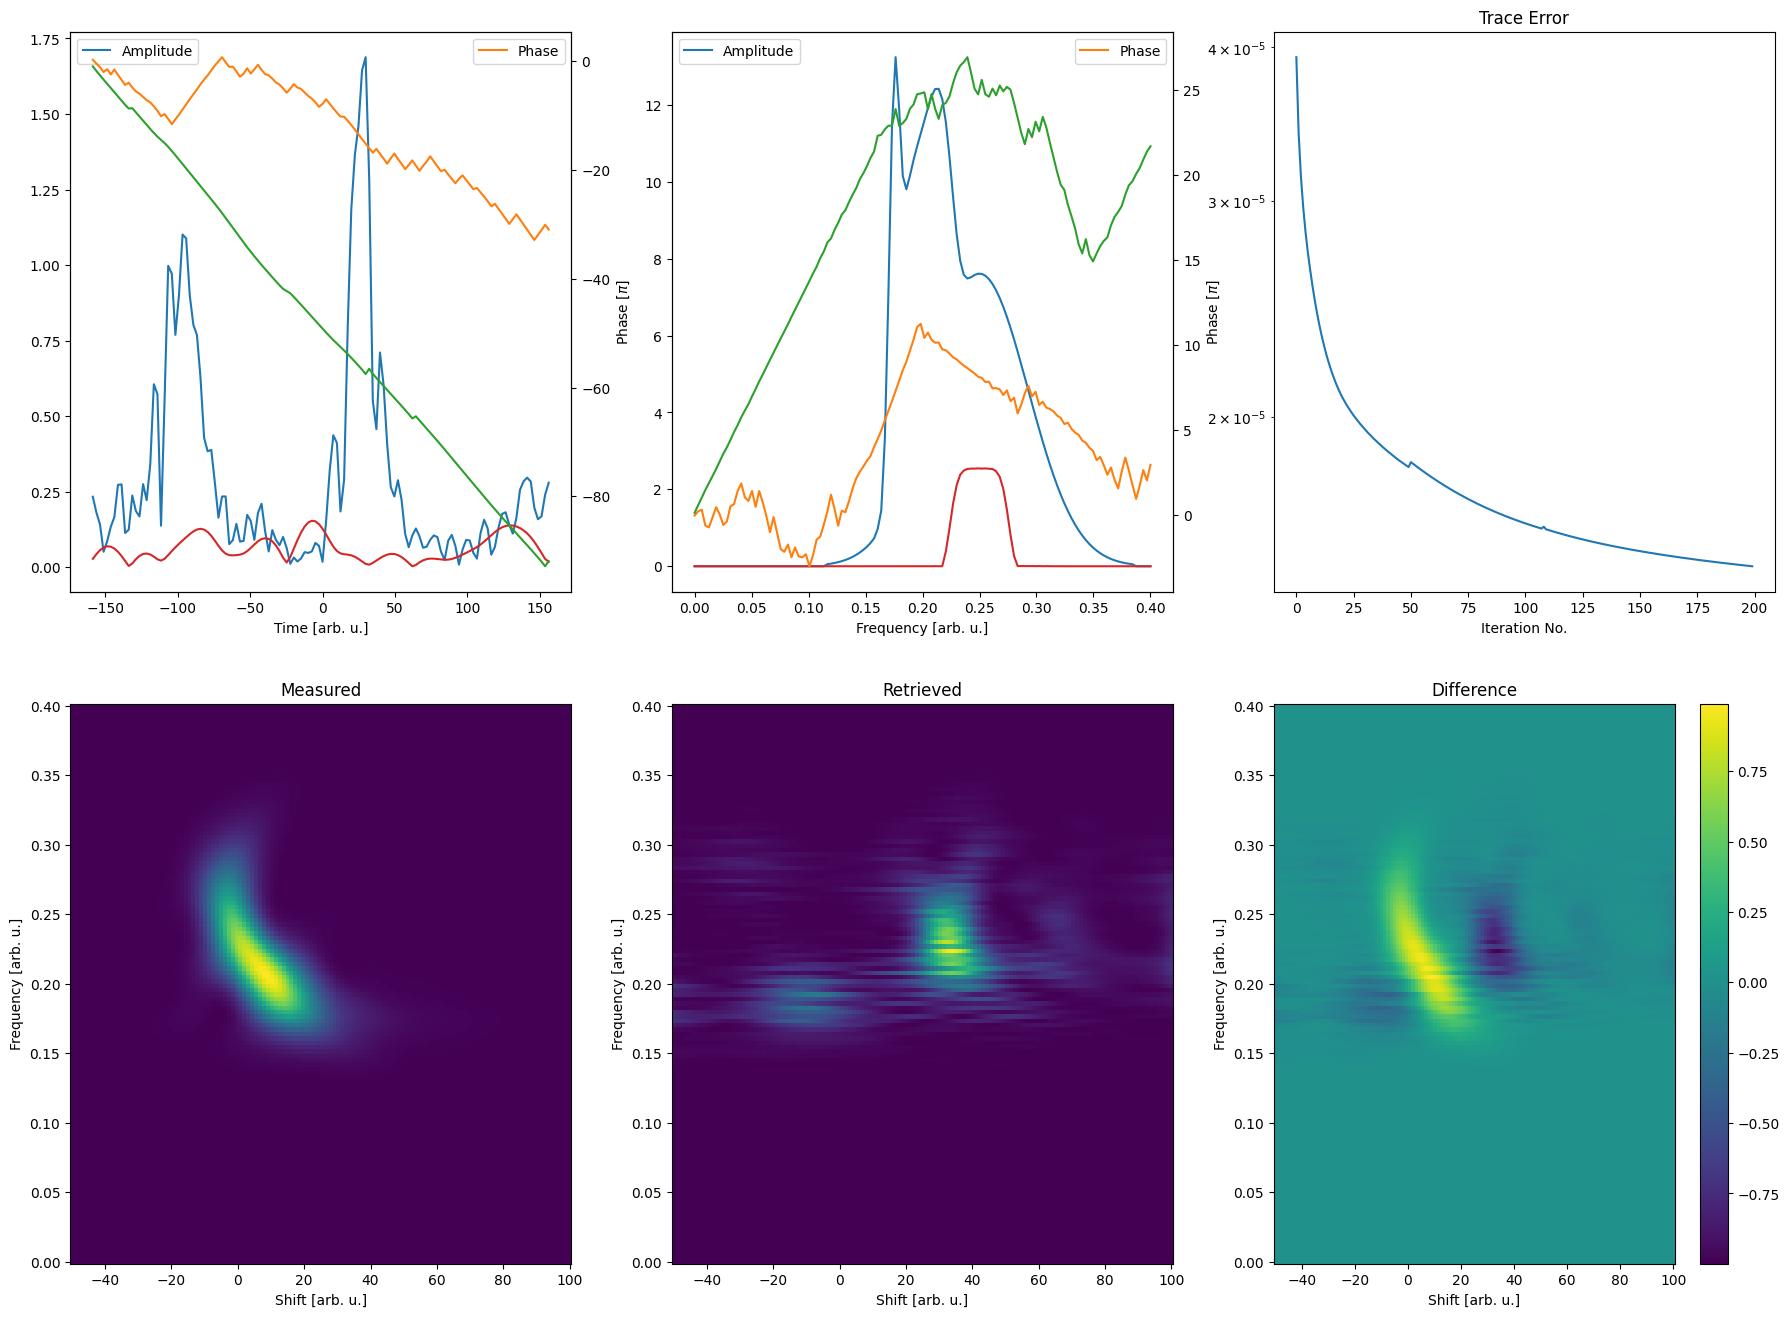

In [26]:
from pulsedjax.frog import PtychographicIterativeEngine

pie = PtychographicIterativeEngine(delay, frequency_trace, trace, "pg", cross_correlation="doubleblind",
                                   pie_method="ePIE")#, cross_correlation="doubleblind")

pie.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
pie.use_measured_spectrum(spectra.gate[0], spectra.gate[1], "gate")

population = pie.create_initial_population(1, "random")

#pie.alpha = 0.15
pie.local_gamma = 1e-2
pie.global_gamma = 1e-1


pie.set_nonlinear_optimization(local_method=False, global_method="full", memory=10)
pie.set_linesearch(method="backtracking", delta_gamma=0.5, max_steps=25)
#pie.set_S_prime_params(global_method="projection")


final_result = pie.run(population, 50, 150)
pie.plot_results(final_result)

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:297: RuntimeWarning: invalid value encountered in divide
  g = lambda c1, c2, w: c1 * (w ** 2) / (w ** 2 - c2 ** 2)
/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


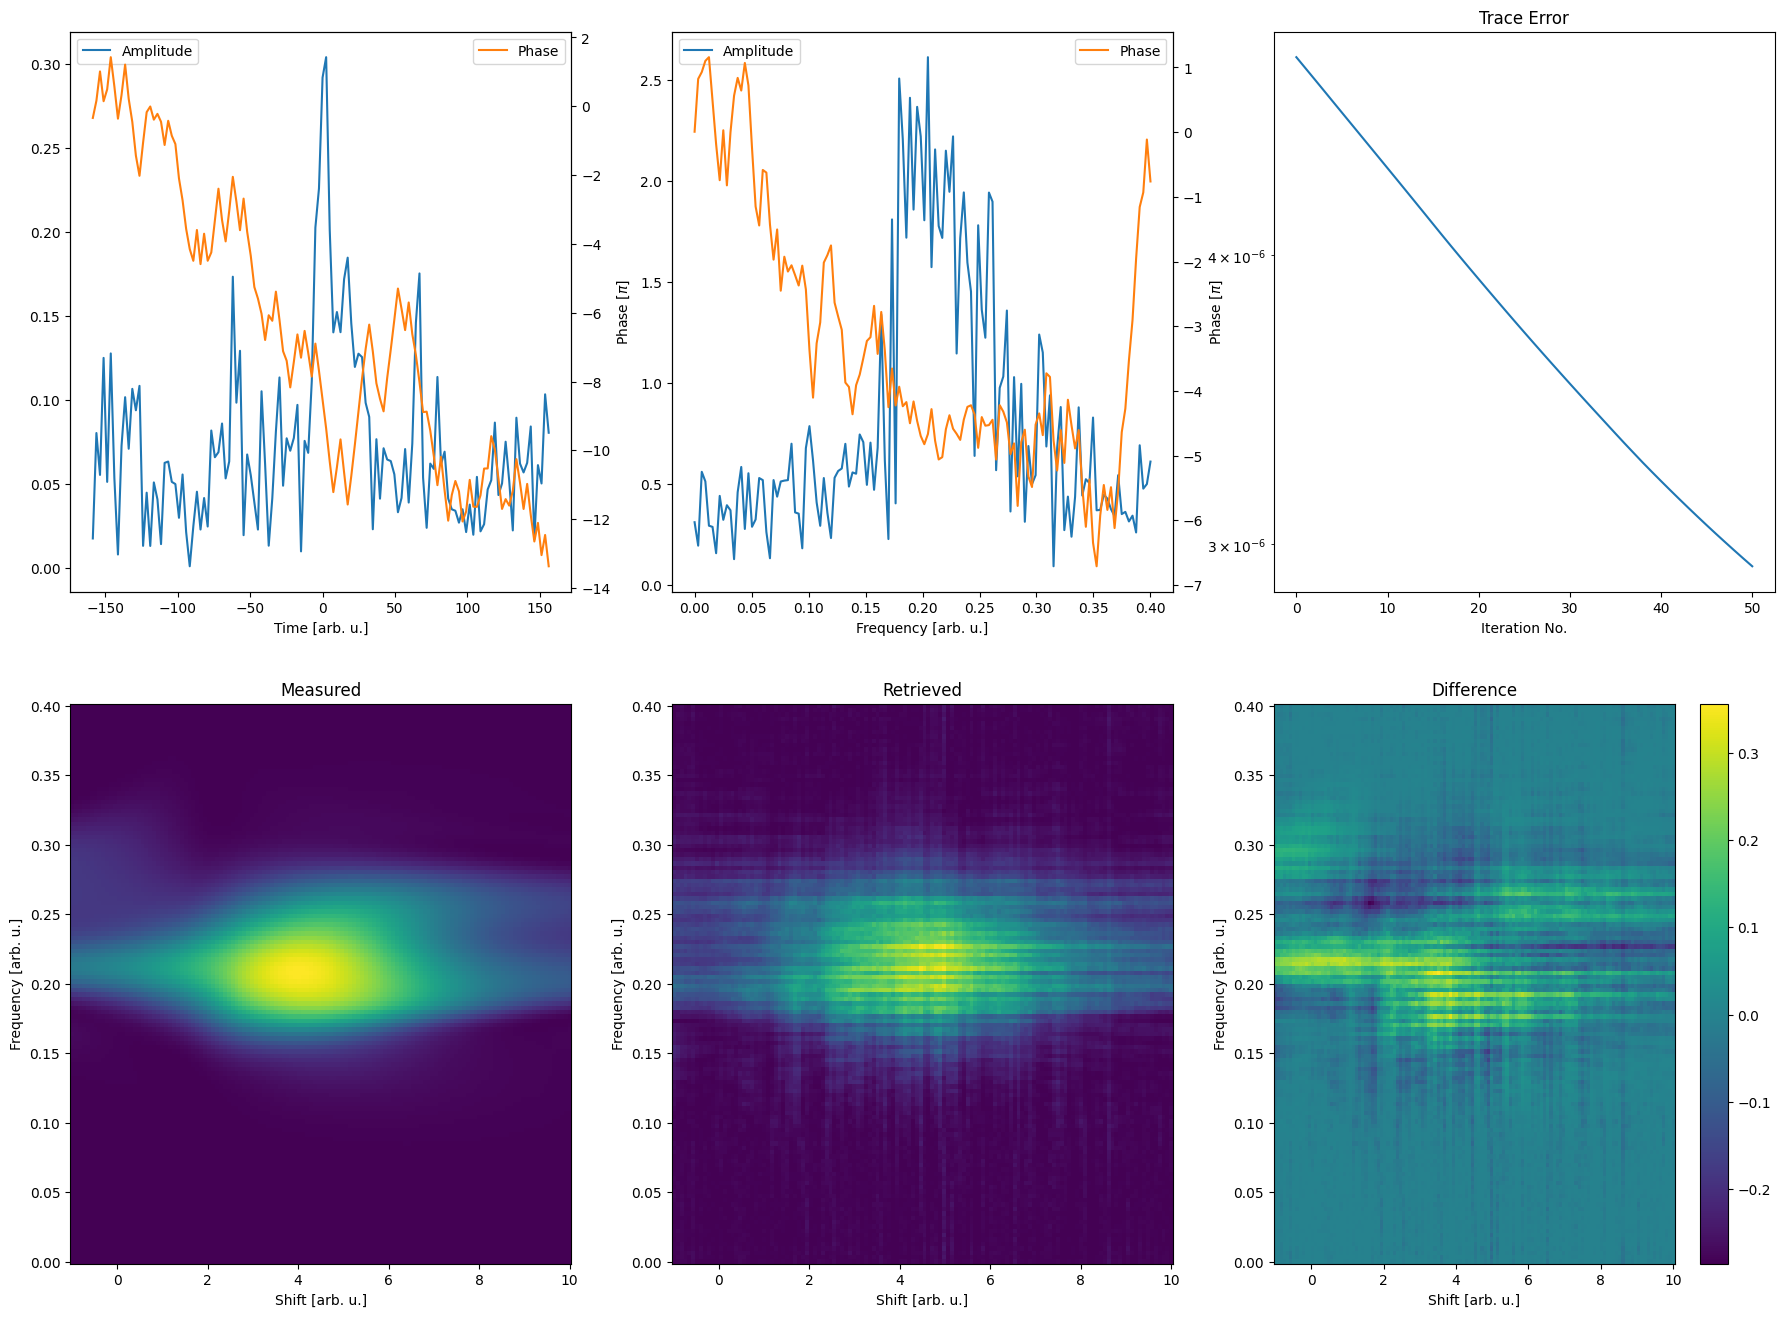

In [5]:
from pulsedjax.chirp_scan import PtychographicIterativeEngine

pie = PtychographicIterativeEngine(theta, frequency_trace, trace, "pg", phase_type="material", 
                                   chirp_parameters=refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson"),
                                   pie_method="ePIE")#, cross_correlation="doubleblind")

# pie.use_measured_spectrum(spectra.pulse[0], spectra.pulse[1], "pulse")
# pie.use_measured_spectrum(spectra.gate[0], spectra.gate[1], "gate")

population = pie.create_initial_population(1, "random")

#pie.alpha = 0.15
pie.local_gamma = 0.1
pie.global_gamma = 1e8


pie.set_nonlinear_optimization(local_method=False, global_method="full", memory=10)
pie.set_linesearch(method="zoom", delta_gamma=2, max_steps=25)
#pie.set_S_prime_params(global_method="projection")


final_result = pie.run(population, 1, 50)
pie.plot_results(final_result)